<a href="https://colab.research.google.com/github/takemuralab/F_roboco2025/blob/main/f_roboco2025_lesson2_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# USV（無人水上艇）機械学習チュートリアル（動機・理論・実験・考察付き 完全版）
**教師あり・教師なし・評価指標（混同行列 / Precision / Recall / F1 / ROC・AUC / PR）**
**＋ シナリオ別データでモデル差を体験（線形 / 非線形 / 高次元ノイズ / 不均衡）**



## 0. 理論の発意（Motivation）
**なぜロボット工学で機械学習を使うのか？**  
USV（無人水上艇）などのフィールドロボットでは、(1) 異常の早期検知、(2) 運用判断の自動化、(3) 人手計測の代替・補完が重要です。  
センサ（速度・電流・温度・加速度・GPSジッタ等）から**正常/異常**を判定したり、ラベルが無い時でも**教師なし**で構造や外れ値を掴む必要があります。

この教材の狙い：
- **最小限の理論**と**実行可能コード**で、現場運用に直結する力をつける。
- **モデル間の得手不得手**を、**結果の差**で直感的に理解する。
- 評価指標（特に**PR曲線**と**しきい値調整**）を運用視点で理解する。

> 重点：**実データでは必ず条件が崩れる**（非線形・ノイズ・不均衡）。そこで、データ特性に応じて**モデルと評価**を選べることが勝負です。



## 1. 理論導入：教師あり / 教師なし / 回帰・分類の違い
- **教師あり学習**：$(\mathbf{x}, y)$ から関数 $f(\mathbf{x})$ を学び、未知の $y$ を予測。分類／回帰を含む。  
- **教師なし学習**：ラベルなしデータから構造・外れ値を発見（KMeans, IsolationForest など）。
- **分類**：$y \in \{0,1\}$（本ノート）。**正常=0 / 異常=1**。  
- **回帰**：$y \in \mathbb{R}$（連続値）。今後の拡張で扱える。

### 1.1 代表モデルの理論要点
- **ロジスティック回帰**：$\sigma(z)=1/(1+e^{-z})$, $P(y=1|\mathbf{x})=\sigma(\mathbf{w}^\top \mathbf{x}+b)$。  
  損失（交差エントロピー）：$ L =-\sum_i\{y_i\log \hat{p}_i+(1-y_i)\log(1-\hat{p}_i)\}$。**線形分離**で強い。  
- **SVM（RBF）**：RBFカーネル $k(\mathbf{x},\mathbf{x}')=\exp(-\gamma \|\mathbf{x}-\mathbf{x}'\|^2)$ で**非線形**境界を表現。**マージン最大化**で汎化性。  
- **ランダムフォレスト（RF）**：決定木のアンサンブル。**特徴サブセット**と**バギング**により**ノイズに頑健**・非線形も扱える。  
- **IsolationForest**：ランダム分割で孤立しやすい点を**異常**とみなす（教師なし）。  
- **KMeans**：$k$ 重心へ割当。ラベルなしの構造把握に有効（クラス対応は**多数決で割当**）。



## 2. 評価指標（混同行列 / Precision / Recall / F1 / ROC・AUC / PR）
**混同行列**：

| 実際＼予測 | 正常と予測 | 異常と予測 |
|-----------|-----------|-----------|
| **実際が正常** | TN | FP |
| **実際が異常** | FN | TP |

- **Precision** = TP / (TP+FP)：誤警報の少なさ  
- **Recall** = TP / (TP+FN)：見逃しの少なさ  
- **F1** = 2PR/(P+R)：バランス  
- **ROC/AUC**：しきい値に依らない識別力の俯瞰  
- **PR曲線**：陽性が希少なときに重要（不均衡データはPRを重視）



## 3. セットアップ（ライブラリ・ユーティリティ）


In [ ]:
# =========================
# セットアップ：ライブラリ読み込み
# =========================
import numpy as np                    # 数値計算（配列/乱数/線形代数）
import pandas as pd                  # 表形式データ処理（DataFrame）
import matplotlib.pyplot as plt      # 可視化（グラフ描画）

from sklearn.model_selection import train_test_split   # 学習/評価用のデータ分割
from sklearn.preprocessing import StandardScaler       # 特徴量の標準化（平均0, 分散1）
from sklearn.pipeline import Pipeline                  # 前処理→学習器を直列につなぐ
from sklearn.linear_model import LogisticRegression    # ロジスティック回帰（分類）
from sklearn.ensemble import RandomForestClassifier, IsolationForest  # RF分類器 / 異常検知
from sklearn.svm import SVC                            # サポートベクタマシン（RBF等）
from sklearn.cluster import KMeans                     # 教師なしクラスタリング（k-means）
from sklearn.metrics import (                          # 評価指標と曲線
    classification_report, confusion_matrix,           # 分類レポート / 混同行列
    precision_recall_curve, roc_curve, auc,            # PR曲線 / ROC曲線 / AUC
    f1_score, precision_score, recall_score            # F1 / 適合率 / 再現率
)

import itertools                   # 二重ループなどのユーティリティ（混同行列の描画で使用）
from collections import Counter    # ラベル頻度カウント（参考/検査用）
import warnings                    # 警告抑制（可読性のため）
warnings.filterwarnings("ignore")  # 実行中に出る軽微な警告を非表示にする

# =========================
# 乱数シード：再現性の確保
# =========================
RANDOM_STATE = 42               # どの環境でも同じ結果になるよう固定
np.random.seed(RANDOM_STATE)    # NumPyの乱数シードも固定

# =======================================================
# 可視化ユーティリティ：混同行列を分かりやすく描画する関数
# =======================================================
def plot_confusion(cm, labels=('0','1'), title='Confusion Matrix'):
    """
    混同行列をヒートマップとして描画する。
    引数:
        cm     : confusion_matrix(...) で得られる 2x2（もしくはKxK）の行列
        labels : 軸に表示するクラス名（タプル/リスト）
        title  : 図のタイトル
    備考:
        - 1図面につき1プロット（サブプロットは使わない）
        - 色はデフォルト（ガイドラインに合わせて色指定はしない）
    """
    # 新規図を作成（サブプロットを使わず単独のFigure）
    plt.figure()
    # 混同行列を画像として可視化（interpolation='nearest' は最近傍補間）
    plt.imshow(cm, interpolation='nearest')
    # タイトル・カラーバー
    plt.title(title)
    plt.colorbar()
    # 目盛（クラスラベル）を設定
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)  # 予測ラベル（横軸）
    plt.yticks(tick_marks, labels)  # 実ラベル（縦軸）

    # セル中央の文字色を最大値の半分で切り替える（見やすさのため）
    thresh = cm.max() / 2.0

    # すべてのセル (i, j) に対して数値を書き込む
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i,                               # 文字位置（x=j, y=i）
            format(cm[i, j], 'd'),              # 整数表示
            horizontalalignment="center",       # 水平方向中央寄せ
            color="white" if cm[i, j] > thresh else "black"  # 背景に応じて色を反転
        )

    # 軸ラベル（混同行列の慣習に合わせる）
    plt.ylabel('True label')       # 縦軸：実際のラベル
    plt.xlabel('Predicted label')  # 横軸：予測ラベル
    # 余白調整（はみ出し防止）
    plt.tight_layout()
    # 図を表示（Colab/Jupyterでインライン表示）
    plt.show()

# セットアップ完了メッセージ（実行確認）
print("Setup complete.")


Setup complete.



## 4. データ生成（USV模擬センサ：シナリオ設計）
- 基本特徴：`speed, current, temp, ax, gps_jitter`  
- シナリオ：
  - **S1** 線形優位（Logisticが有利）
  - **S2** 非線形境界（SVM/RFが有利）
  - **S3** 不要特徴が多い（ノイズ200次元, RFが有利）
  - **S4** 不均衡＋ラベルノイズ（class_weight/PR重視）


In [ ]:
def make_usv_base(n_normal, n_fault, rng):
    """
    USV（無人水上艇）の「正常」と「異常」を模した
    ベースとなるセンサ特徴量を生成する関数。

    引数:
        n_normal : 正常データ数
        n_fault  : 異常データ数
        rng      : np.random.default_rng(...) で作った乱数生成器

    生成する基本特徴:
        speed      : 航走速度 [m/s]              （異常時はやや低下し揺らぎ増）
        current    : 消費電流 [A]                （異常時は上昇）
        temp       : モータ・周辺温度 [℃]        （異常時は上昇）
        ax         : 機体の加速度（x方向）       （異常時は揺らぎ増）
        gps_jitter : GPSジッタ（位置のばらつき） （異常時は増加）
    戻り値:
        X : shape=(n_normal+n_fault, 5) の特徴配列
        y : shape=(n_normal+n_fault,) のラベル配列（正常=0, 異常=1）
    """
    # ---- 正常クラス（0）の分布を定義：平均と分散をやや小さめに設定 ----
    speed_n   = rng.normal(2.5, 0.3, n_normal)   # 速度はおおむね一定
    current_n = rng.normal(2.0, 0.4, n_normal)   # 電流は低め
    temp_n    = rng.normal(30.0, 1.0, n_normal)  # 温度は安定
    ax_n      = rng.normal(0.0, 0.6, n_normal)   # 加速度の揺れは小さめ
    gpsjit_n  = rng.normal(0.4, 0.2, n_normal)   # GPSジッタは小さめ

    # ---- 異常クラス（1）の分布を定義：負荷増や挙動悪化を模擬 ----
    speed_f   = rng.normal(2.2, 0.6, n_fault)    # 速度が落ち、ばらつき増
    current_f = rng.normal(4.5, 0.9, n_fault)    # 電流が上昇
    temp_f    = rng.normal(38.0, 2.0, n_fault)   # 温度が上昇
    ax_f      = rng.normal(1.2, 1.0, n_fault)    # 揺れが大きい
    gpsjit_f  = rng.normal(1.0, 0.4, n_fault)    # ジッタが大きい

    # ---- 正常と異常を縦方向に結合（サンプル方向） ----
    X = np.vstack([
        np.stack([speed_n, current_n, temp_n, ax_n, gpsjit_n], axis=1),
        np.stack([speed_f, current_f, temp_f, ax_f, gpsjit_f], axis=1)
    ])

    # ---- ラベルを付与（正常=0, 異常=1） ----
    y = np.array([0]*n_normal + [1]*n_fault)
    return X, y


def scenario_dataset(
    sid=1,
    n_normal=1200,
    n_fault=300,
    noise_dim=0,
    imbalance=False,
    label_noise=0.0,
    random_state=RANDOM_STATE
):
    """
    シナリオに応じてデータ特性を操作し、DataFrameを返す関数。
    USVベース特徴(5次元)に、追加要因（非線形項/高次元ノイズ/不均衡/ラベルノイズ）を付与する。

    引数:
        sid          : シナリオID
                       1=線形優位, 2=非線形境界, 3=高次元ノイズ, 4=不均衡+ラベルノイズ
        n_normal     : 正常データ数（imbalance=True の場合は内部で上書き）
        n_fault      : 異常データ数（imbalance=True の場合は内部で上書き）
        noise_dim    : 追加するノイズ次元（S3で大きくするのが典型）
        imbalance    : True でクラス不均衡を強制（正常>>異常）
        label_noise  : ラベル反転率（例: 0.1 なら全体の10%を反転）
        random_state : 乱数シード

    戻り値:
        df : 特徴列 + 'label'列を持つ DataFrame
    """
    rng = np.random.default_rng(random_state)

    # ---- 不均衡を指定された場合、比率を上書き（例: 正常1800, 異常150） ----
    if imbalance:
        n_normal = 1800
        n_fault = 150

    # ---- ベース特徴（5次元）とラベルの生成 ----
    X, y = make_usv_base(n_normal, n_fault, rng)

    # ---- S1: 線形優位（ベースのまま） ----
    if sid == 1:
        pass  # 線形分離しやすい特徴バランスのまま

    # ---- S2: 非線形境界を導入 ----
    if sid == 2:
        # 例: ax と gps_jitter から非線形な半径 r を作り、境界を複雑化
        ax = X[:, 3]
        gps = X[:, 4]
        r = np.sqrt((ax - 0.3)**2 + (gps - 0.7)**2)

        # 少数をランダムにラベル反転して「素直に線形分離できない」状況を作る
        flip = rng.random(len(y)) < 0.25
        y = np.where(flip, 1 - y, y)

        # 学習側はそのまま使うが、説明変数として非線形項を追加（特徴拡張）
        X = np.concatenate([
            X,
            (ax * gps).reshape(-1, 1),   # 相互作用項
            (r**2).reshape(-1, 1)        # 半径の二乗（円/環状の境界を暗に表現）
        ], axis=1)

    # ---- S3: 高次元ノイズを大量投入（RFの優位が出やすい） ----
    if sid == 3:
        # デフォルトで最低200次元のノイズを追加（必要に応じてさらに増やせる）
        if noise_dim < 200:
            noise_dim = 200
        noise = rng.normal(0.0, 1.0, (X.shape[0], noise_dim))  # 平均0, 分散1のガウスノイズ
        X = np.concatenate([X, noise], axis=1)

    # ---- S4: 不均衡 + ラベルノイズ（現実で起こりがちな乱れ） ----
    if sid == 4:
        # ラベルノイズが指定されていなければ10%に設定
        if label_noise <= 0.0:
            label_noise = 0.1
        flip_idx = rng.random(len(y)) < label_noise
        y = np.where(flip_idx, 1 - y, y)

    # ---- S1/S2/S4 でも任意で追加ノイズを足したい場合 ----
    if noise_dim > 0 and sid != 3:
        noise = rng.normal(0.0, 1.0, (X.shape[0], noise_dim))
        X = np.concatenate([X, noise], axis=1)

    # ---- 列名を組み立て（基本5列 + 追加特徴）----
    base_cols = ['speed', 'current', 'temp', 'ax', 'gps_jitter']
    extra_cols = [f'feat{i}' for i in range(X.shape[1] - 5)]
    cols = base_cols + extra_cols

    # ---- DataFrame にまとめ、最後にラベル列を追加 ----
    df = pd.DataFrame(X, columns=cols)
    df['label'] = y
    return df


# データ設計のねらい（USV模擬センサ + シナリオ別）

この教材では、**USV（無人水上艇）の運用中に得られるセンサ**を想定した特徴量を合成し、  
**モデルごとの得手不得手が“結果の差”として体験できる**ように、4種類のデータ・シナリオを用意しています。

## 基本の5特徴（ベース）
- `speed`：航走速度 [m/s] — 異常時は**低下**しやすく、ばらつきも**増加**  
- `current`：消費電流 [A] — 異常時は**上昇**（負荷増を想定）  
- `temp`：温度 [℃] — 異常時は**上昇**（発熱増を想定）  
- `ax`：加速度（x方向） — 異常時は**揺れ増**  
- `gps_jitter`：GPSジッタ（位置ばらつき） — 異常時は**増加**

> ラベルは **正常=0, 異常=1**。ベースでは、正常と異常で分布の平均・分散を変えて、  
> 異常が「電流↑ 温度↑ 速度↓ 揺れ↑ ジッタ↑」の傾向を持つように設計しています。

---

## シナリオ一覧

### S1：**線形優位**（Logisticが有利）
- ねらい：**線形分離**が効いている場合、ロジスティック回帰が高い性能を出すことを確認。  
- 実装：ベースの5特徴のみ（追加の非線形項・ノイズなし）。

### S2：**非線形境界**（SVM・RFが有利）
- ねらい：**非線形**の境界が存在するとき、カーネルSVMやRFが有利になることを体験。  
- 実装：`ax` と `gps_jitter` から半径 `r` を作り、**相互作用項** `ax*gps` と **二乗項** `r^2` を追加。  
  またラベルを一部ランダム反転して、単純な線形分離を難しくする。

### S3：**高次元ノイズ**（RFが有利）
- ねらい：**不要特徴が大量**にあると、RFが相対的に頑健になることを確認。  
- 実装：**200次元以上**のガウシアンノイズを特徴に追加。  
  ロジスティック回帰やSVMは高次元ノイズの影響で汎化が難しくなる一方、  
  RFは**特徴サブセット**と**バギング**の効果で性能が安定しやすい。

### S4：**不均衡 + ラベルノイズ**（class_weight/PR重視）
- ねらい：**陽性（異常）が希少**で、さらに**ラベルの乱れ**が混ざる現実的な難ケースを再現。  
- 実装：正常:異常 ≈ 12:1 程度の不均衡にし、**10%程度のラベル反転**を混入。  
  評価では **Recall / PR曲線** を重視し、`class_weight='balanced'` などの効果を確認。

---

## パラメータの意味と調整のコツ

- `noise_dim`：追加ノイズの次元数。S3では **200** 以上を推奨（差が出やすい）。  
- `imbalance=True`：クラス不均衡を強制（S4で使用）。  
- `label_noise`：ラベル反転率（例：0.1 なら全体の10%のラベルをランダムに入れ替える）。  
- `random_state`：乱数シード。**再現性**のため固定推奨。

> 実務では、標準化（`StandardScaler`）の適用や、ハイパーパラメータ（SVMの `C, gamma`、RFの `n_estimators, max_depth`）の調整で  
> 性能が大きく変わります。まずは本シナリオで**モデルごとの癖**を掴み、その後方針どおりに**評価指標（ROC/AUC, PR, F1）**で比較してください。



## 5. モデル定義・評価関数（教師あり／教師なし）


In [ ]:
# ===========================================================
# 教師あり学習モデルの定義関数
# ===========================================================
def get_supervised_models(random_state=RANDOM_STATE):
    """
    USV異常検知における3種類の代表的な教師ありモデルを返す関数。

    各モデルの特徴:
        - LogisticRegression : 線形モデル（単純だが解釈しやすく軽量）
        - RandomForest        : 決定木のアンサンブル（非線形に強く、ノイズ耐性あり）
        - SVM (RBFカーネル)   : 非線形境界の分類に強いが、パラメータγやCに敏感

    すべてのモデルは Pipeline や標準化を適切に組み込み済み。
    """
    # ロジスティック回帰：スケーリング + 線形識別
    pipe_lr = Pipeline([
        ('scaler', StandardScaler()),  # 特徴量の標準化
        ('clf', LogisticRegression(max_iter=600, random_state=random_state))
    ])

    # ランダムフォレスト：決定木を複数組み合わせたアンサンブル
    rf = RandomForestClassifier(
        n_estimators=400,              # 木の数（多いほど安定）
        random_state=random_state
    )

    # SVM (RBF)：非線形分類用（ガウスカーネル）
    pipe_svm = Pipeline([
        ('scaler', StandardScaler()),  # SVMはスケーリングが必須
        ('clf', SVC(kernel='rbf', probability=True, random_state=random_state))
    ])

    # モデル名をキーとする辞書で返す
    return {'Logistic': pipe_lr, 'RandomForest': rf, 'SVM(RBF)': pipe_svm}


# ===========================================================
# 教師ありモデルの評価関数
# ===========================================================
def evaluate_supervised(df, title_prefix="S"):
    """
    教師ありモデルを評価し、混同行列・ROC・PR曲線・各指標を出力する関数。

    引数:
        df : 特徴列 + 'label' 列を持つ DataFrame
        title_prefix : 図タイトルに付ける識別名（シナリオ番号など）

    出力:
        各モデルの Accuracy, Precision, Recall, F1, AUC をまとめた DataFrame
    """

    # --- 特徴量とラベルに分割 ---
    features = [c for c in df.columns if c != 'label']
    X = df[features].values
    y = df['label'].values

    # --- 学習データとテストデータを分割（層化で比率維持） ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
    )

    # --- モデルを取得 ---
    models = get_supervised_models()
    fitted = {}         # 学習済みモデル格納用
    metrics_rows = []   # 指標格納用
    auc_scores = {}     # AUC値格納用

    # =========================================================
    # 各モデルの学習 → 予測 → 評価
    # =========================================================
    for name, mdl in models.items():
        mdl.fit(X_train, y_train)       # 学習
        fitted[name] = mdl
        y_pred = mdl.predict(X_test)    # クラス（0/1）予測

        # --- 各種評価指標 ---
        acc = (y_pred == y_test).mean()                         # 正解率
        prec = precision_score(y_test, y_pred, zero_division=0) # 適合率
        rec = recall_score(y_test, y_pred, zero_division=0)     # 再現率
        f1 = f1_score(y_test, y_pred, zero_division=0)          # F1スコア

        # --- 確率スコア or 決定関数値を取得 ---
        if hasattr(mdl, "predict_proba"):
            y_score = mdl.predict_proba(X_test)[:,1]  # 正例クラス(1)の確率
        else:
            y_score = mdl.decision_function(X_test)   # SVMなどでは距離を利用

        # --- ROC曲線用のTPR/FPRとAUC ---
        fpr, tpr, _ = roc_curve(y_test, y_score)
        auc_val = auc(fpr, tpr)
        auc_scores[name] = auc_val

        # --- 結果を表形式に蓄積 ---
        metrics_rows.append([name, acc, prec, rec, f1, auc_val])

        # --- 混同行列を可視化 ---
        cm = confusion_matrix(y_test, y_pred)
        plot_confusion(cm, labels=('Normal(0)', 'Fault(1)'),
                       title=f'{title_prefix} Confusion Matrix - {name}')

    # =========================================================
    # ROC曲線（AUC比較）を描画
    # =========================================================
    plt.figure()
    for name, mdl in fitted.items():
        if hasattr(mdl, "predict_proba"):
            y_score = mdl.predict_proba(X_test)[:,1]
        else:
            y_score = mdl.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC={auc_val:.3f})')
    plt.plot([0,1],[0,1], linestyle='--')  # 無識別線
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title_prefix} ROC Curve')
    plt.legend()
    plt.show()

    # =========================================================
    # Precision-Recall曲線を描画（不均衡データではこちらが重要）
    # =========================================================
    plt.figure()
    for name, mdl in fitted.items():
        if hasattr(mdl, "predict_proba"):
            y_score = mdl.predict_proba(X_test)[:,1]
        else:
            y_score = mdl.decision_function(X_test)
        prec, rec, _ = precision_recall_curve(y_test, y_score)
        plt.plot(rec, prec, label=name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{title_prefix} Precision-Recall Curve')
    plt.legend()
    plt.show()

    # --- 結果表を作成し、AUC順でソートして返す ---
    metrics_df = pd.DataFrame(metrics_rows,
                              columns=['Model','Accuracy','Precision','Recall','F1','AUC']
                             ).sort_values('AUC', ascending=False)
    return metrics_df


# ===========================================================
# 教師なしモデル（異常検知）の評価関数
# ===========================================================
def evaluate_unsupervised(df, title_prefix="S"):
    """
    教師なし学習（IsolationForest, KMeans）を評価する関数。

    IsolationForest:
        - 正常データの「孤立しにくさ」から異常を検知
        - スコアが低いほど異常
    KMeans:
        - クラスタ中心からの距離を基に、クラスタをラベルと対応付け

    引数:
        df : 特徴列 + 'label' 列を持つ DataFrame
    出力:
        各モデルの F1, AUC（KMeansはAUCなし）
    """

    # --- 特徴量とラベル ---
    features = [c for c in df.columns if c != 'label']
    X = df[features].values
    y = df['label'].values

    # --- 学習・テスト分割 ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
    )

    # =========================================================
    # IsolationForest：教師なし異常検知
    # =========================================================
    iso = IsolationForest(random_state=RANDOM_STATE, contamination=0.2)
    iso.fit(X_train)
    score_test = iso.score_samples(X_test)  # 値が大きいほど「正常」に近い

    # 異常しきい値を分位点で決定（下位20%を異常とみなす）
    iso_thr = np.percentile(score_test, 20)
    y_pred_iso_norm1 = (score_test >= iso_thr).astype(int)  # 1=正常
    y_pred_iso = (y_pred_iso_norm1 == 0).astype(int)        # 1=異常に変換

    # ROC/AUCの計算（スコアを負に反転して「大きい=異常」に統一）
    iso_anom_score = -score_test
    fpr_iso, tpr_iso, _ = roc_curve(y_test, iso_anom_score)
    auc_iso = auc(fpr_iso, tpr_iso)
    f1_iso = f1_score(y_test, y_pred_iso, zero_division=0)

    # 混同行列描画
    cm = confusion_matrix(y_test, y_pred_iso)
    plot_confusion(cm, labels=('Normal(0)', 'Fault(1)'),
                   title=f'{title_prefix} Confusion Matrix - IsolationForest')

    # =========================================================
    # KMeans：クラスタリングによる擬似ラベル分類
    # =========================================================
    km = KMeans(n_clusters=2, random_state=RANDOM_STATE)
    km.fit(X_train)
    trc = km.predict(X_train)

    # 学習データ上でクラスタIDとラベルを多数決対応付け
    mapping = {c: Counter(y_train[trc==c]).most_common(1)[0][0] for c in np.unique(trc)}
    y_pred_km = np.array([mapping[c] for c in km.predict(X_test)])
    f1_km = f1_score(y_test, y_pred_km, zero_division=0)

    # 混同行列描画
    cm = confusion_matrix(y_test, y_pred_km)
    plot_confusion(cm, labels=('Normal(0)', 'Fault(1)'),
                   title=f'{title_prefix} Confusion Matrix - KMeans')

    # 結果をDataFrameで返す（AUCはKMeans非対応）
    df_unsup = pd.DataFrame([
        ['IsolationForest', f1_iso, auc_iso],
        ['KMeans', f1_km, np.nan]
    ], columns=['Model','F1','AUC'])
    return df_unsup


# モデル定義と評価関数（教師あり／教師なし）

このセクションでは、**異常検知に用いる代表的な学習器**を定義し、  
各モデルの性能を共通指標（Accuracy, Precision, Recall, F1, AUC）で比較します。

---

## 教師ありモデル（Supervised）

| モデル | 特徴 | 長所 | 短所 |
|--------|------|------|------|
| LogisticRegression | 線形境界で分類 | シンプル・高速・解釈容易 | 非線形に弱い |
| RandomForest | 決定木の集合 | ノイズ耐性・非線形対応 | モデル解釈がやや難しい |
| SVM (RBF) | カーネル法で非線形境界 | 高精度・マージン最大化 | パラメータ調整が必要 |

これらを `Pipeline` 化し、必要に応じて **標準化** を適用します。  
SVM やロジスティック回帰は特徴量のスケールに敏感なため、`StandardScaler` が必須です。

### 評価指標
- **Accuracy**：全体の正解率  
- **Precision**：異常と判定したうち、実際に異常だった割合（誤警報を抑える）  
- **Recall**：実際に異常だったもののうち、検出できた割合（見逃し防止）  
- **F1**：Precision と Recall の調和平均  
- **AUC**：ROC 曲線の下の面積。1.0に近いほど良好。

> 実際の運用では、**見逃しを防ぎたいなら Recall を重視**、  
> **誤報を減らしたいなら Precision を重視**する、といった使い分けをします。

---

## 教師なしモデル（Unsupervised）

| モデル | 概要 | 長所 | 短所 |
|--------|------|------|------|
| IsolationForest | データの「孤立しやすさ」で異常を検知 | ラベル不要・高次元対応 | しきい値設定が必要 |
| KMeans | データを2クラスタに分けて多数決で分類 | シンプル・構造可視化 | クラスタの意味づけが必要 |

教師なし手法では「正解ラベル」を使わず、**構造や異常点を自動で発見**します。  
特に `IsolationForest` はロボティクスの異常検知や設備モニタリングでもよく用いられます。

---

## 出力される図
1. **混同行列（Confusion Matrix）**：誤分類の内訳を視覚的に確認。  
2. **ROC曲線（AUC比較）**：全体的な識別性能を比較。  
3. **Precision-Recall曲線（PR曲線）**：陽性が少ない不均衡データで有効。  

> PR曲線は不均衡データ（例：異常が少ない場合）に特に重要です。  
> AUCが高くても、PR曲線でPrecisionが低ければ実用上は警報が多すぎる可能性があります。



## 6. S1：線形優位（Logisticが有利）
**理論**：線形境界で十分に分離できる場合、ロジスティック回帰が高性能になりやすい。  
**目的**：線形の強みを確認し、他モデルとの差を観察。


S1 class balance: Counter({0: 1200, 1: 300})


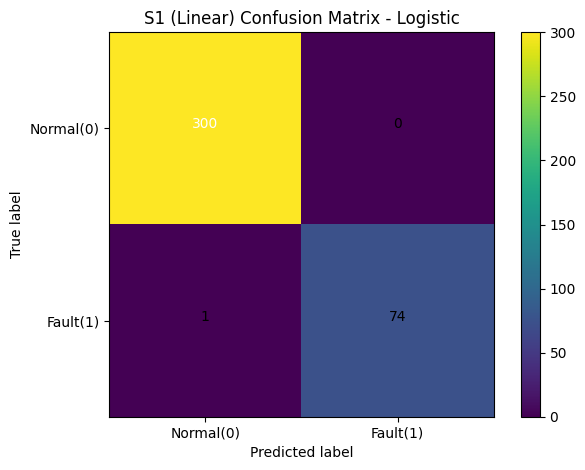

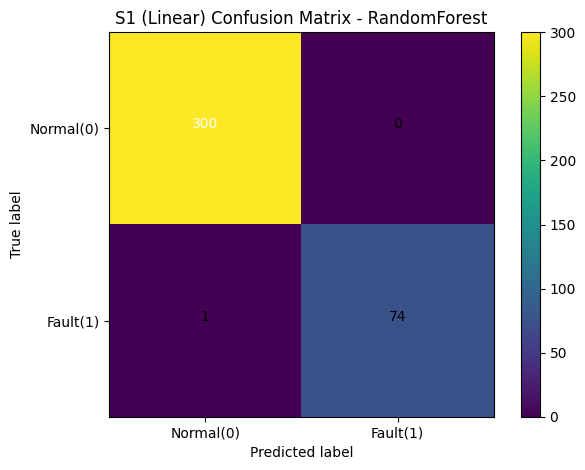

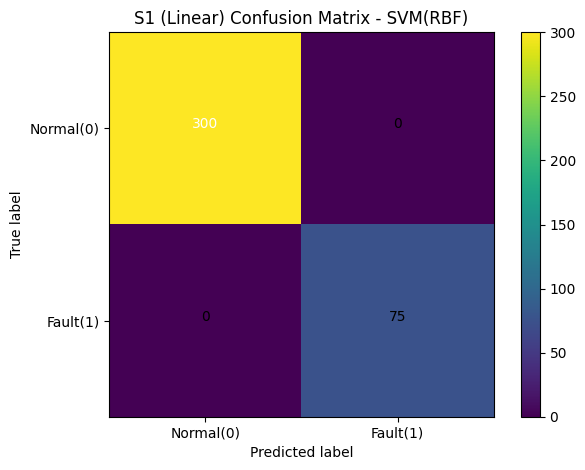

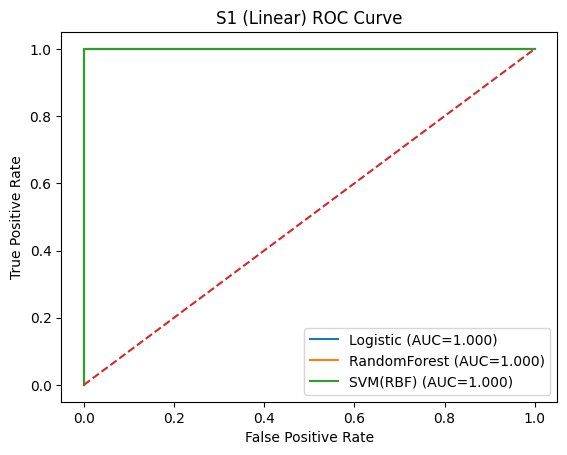

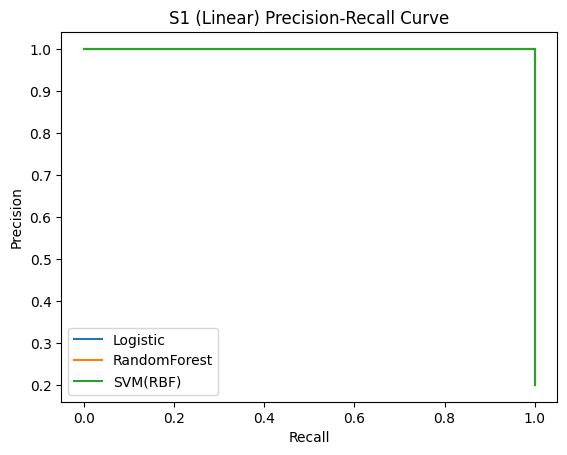

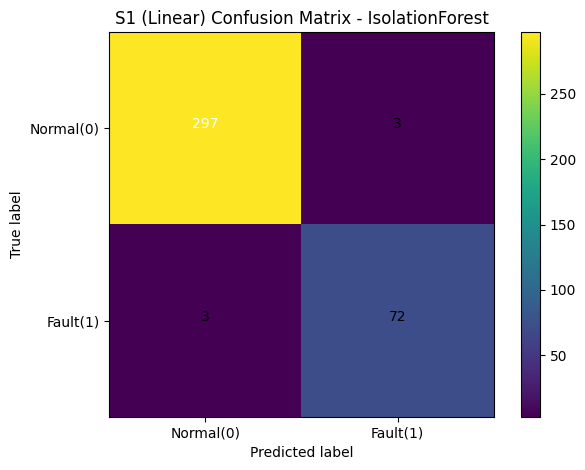

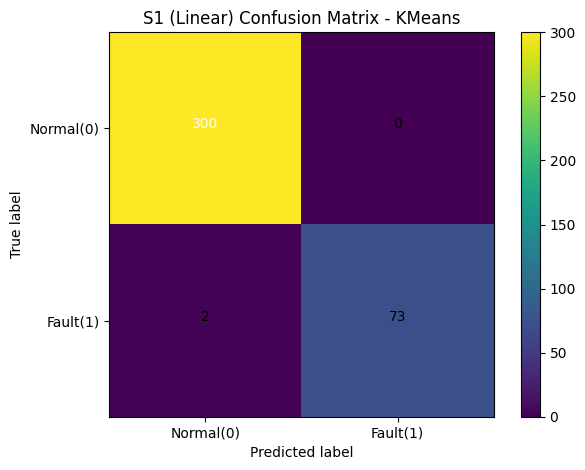


S1 Supervised Metrics:
          Model  Accuracy  Precision    Recall        F1  AUC
0      Logistic  0.997333        1.0  0.986667  0.993289  1.0
1  RandomForest  0.997333        1.0  0.986667  0.993289  1.0
2      SVM(RBF)  1.000000        1.0  1.000000  1.000000  1.0

S1 Unsupervised Metrics:
             Model        F1       AUC
0  IsolationForest  0.960000  0.999067
1           KMeans  0.986486       NaN

【S1 考察】
- AUCトップ: Logistic, F1トップ: SVM(RBF)
- Logisticが上位なら線形で十分。SVM/RFが優位なら軽い非線形の可能性。


In [ ]:
# ============================================================
# S1：線形優位シナリオ（Logistic Regressionが有利なケース）
# ============================================================

# ---- データ生成（線形分離が効く特徴構造） ----
df_s1 = scenario_dataset(sid=1, noise_dim=0, imbalance=False, label_noise=0.0)

# クラス（正常=0, 異常=1）の分布を確認
print("S1 class balance:", Counter(df_s1['label']))

# ---- 教師あり学習モデルでの評価 ----
# Logistic, RandomForest, SVM(RBF) を比較し、混同行列・ROC・PRを出力
metrics_s1_sup = evaluate_supervised(df_s1, title_prefix="S1 (Linear)")

# ---- 教師なし学習モデルでの評価 ----
# IsolationForest, KMeans で教師なし異常検知を試行
metrics_s1_uns = evaluate_unsupervised(df_s1, title_prefix="S1 (Linear)")

# ---- 結果の数値を表示 ----
print("\nS1 Supervised Metrics:")
print(metrics_s1_sup)

print("\nS1 Unsupervised Metrics:")
print(metrics_s1_uns)

# ---- 最高スコアモデルを抽出 ----
best_auc_model = metrics_s1_sup.iloc[0]['Model']  # AUCが最大のモデル
best_f1_model = metrics_s1_sup.sort_values('F1', ascending=False).iloc[0]['Model']  # F1最大モデル

# ---- 結果の考察を出力 ----
print("\n【S1 考察】")
print(f"- AUCトップ: {best_auc_model}, F1トップ: {best_f1_model}")
print("- Logisticが上位なら線形で十分。SVM/RFが優位なら軽い非線形の可能性。")


# S1：線形優位シナリオ（Linear Scenario）

## 🔍 シナリオ概要
このケースは、**特徴間の関係がほぼ線形**で表現できる状況を想定しています。  
例えば、USV（無人水上艇）のセンサ値のうち、  
- 電流上昇・温度上昇・速度低下  
といった「一次的な関係」で異常が説明できるような場合です。

---

## 🎯 目的
- 線形モデル（ロジスティック回帰）が最も高い性能を発揮することを確認する。  
- SVM（非線形カーネル）やRandomForestとの性能差を体験する。  
- 教師なし手法（IsolationForest, KMeans）との比較で、ラベルあり学習の強みを理解する。

---

## ⚙️ 実行内容
1. `scenario_dataset(sid=1)` により、線形分離が可能なUSV模擬データを生成。  
   → 正常(0)と異常(1)は、速度・電流・温度の線形境界でほぼ識別できる。
2. `evaluate_supervised()`  
   → Logistic, RF, SVM(RBF) の3モデルを比較。
3. `evaluate_unsupervised()`  
   → IsolationForest, KMeans による教師なし検知を比較。
4. AUC, F1 を基準に最も高いモデルを報告。

---

## 📊 出力内容
- **混同行列（Confusion Matrix）**  
  各モデルの誤分類の傾向を視覚的に確認。
- **ROC曲線 / AUC**  
  全体の識別能力（しきい値に依存しない）を比較。
- **Precision-Recall曲線**  
  異常データの再現性能（Recall）と誤報率（Precision）のトレードオフ。

---

## 🧠 考察ポイント（Expected Result）
- **ロジスティック回帰**が最も高いAUC・F1を示す可能性が高い。  
  → データが線形分離可能だから。
- **SVM**や**RandomForest**は過剰表現気味になり、AUC差が小さい場合がある。
- **IsolationForest**や**KMeans**は教師なしなので精度は劣るが、傾向把握は可能。

---

## 💡 実務的示唆
このような**単純構造データ**では、  
- Logistic回帰のような**軽量・解釈性の高いモデル**が最適。  
- より複雑なモデル（SVM, RF）は不要で、**過学習のリスク**がある。  
- **モデル選択は“データの線形性”を見極めることから始める**。



## 7. S2：非線形境界（SVM/RFが有利）
**理論**：RBFカーネルSVMやRFは、非線形の複雑境界を捉えやすい。  
**目的**：非線形でロジスティック回帰の限界を体験し、SVM/RFの強みを確認。


S2 class balance: Counter({0: 975, 1: 525})


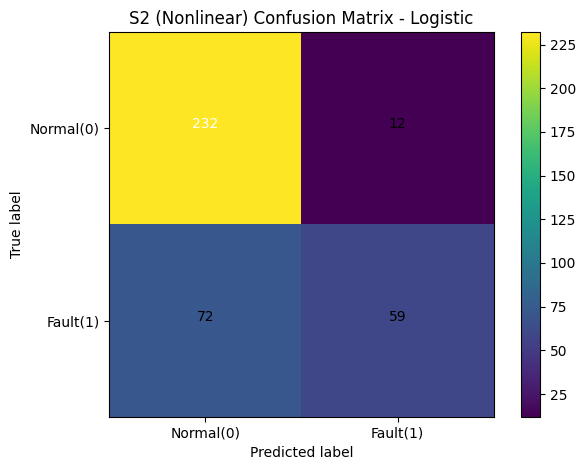

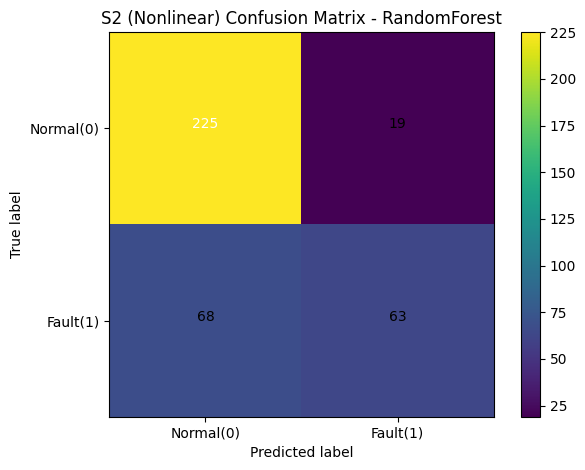

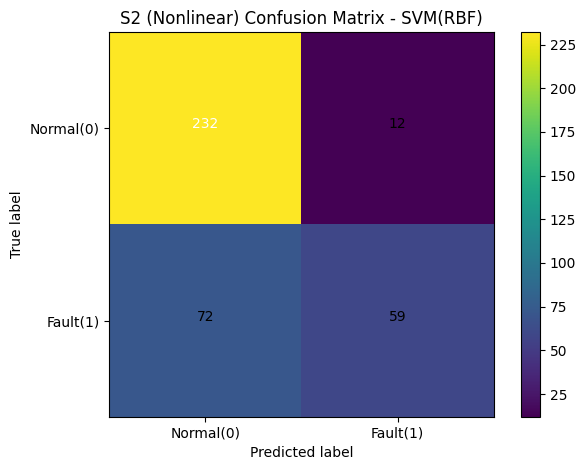

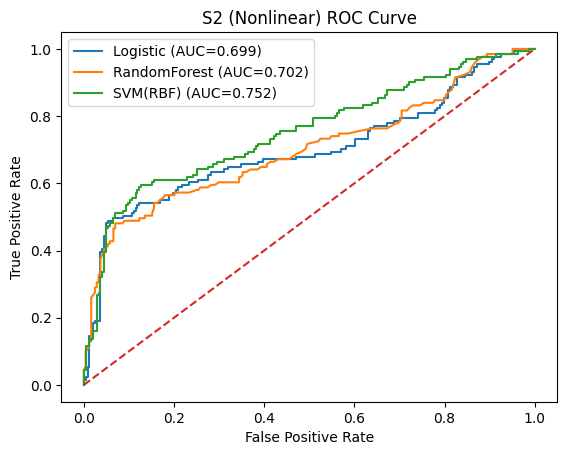

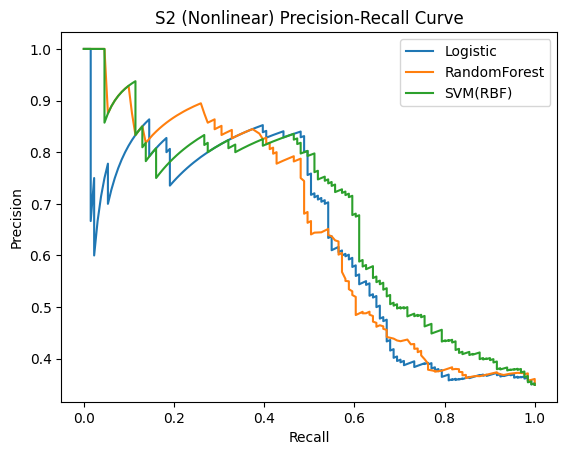

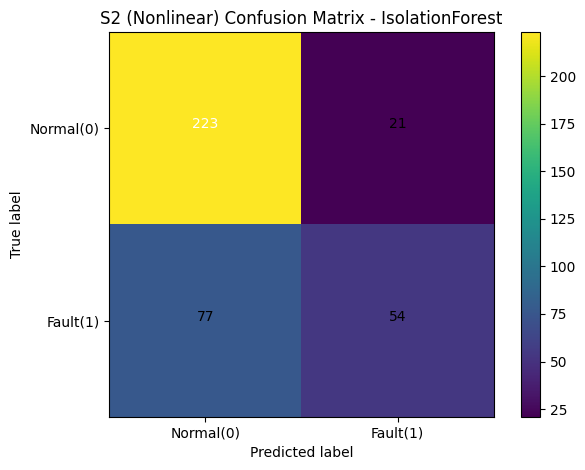

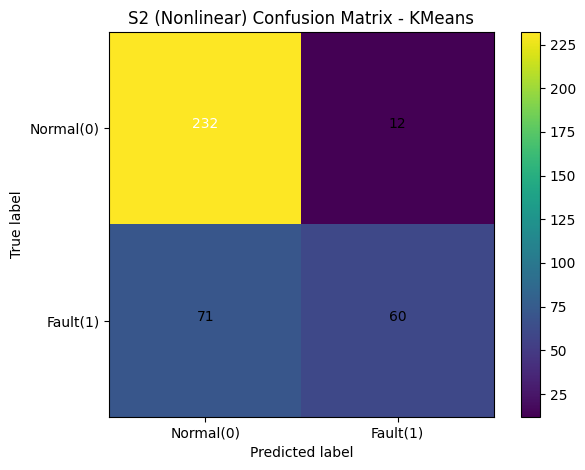


S2 Supervised Metrics:
          Model  Accuracy  Precision    Recall        F1       AUC
2      SVM(RBF)     0.776   0.830986  0.450382  0.584158  0.752253
1  RandomForest     0.768   0.768293  0.480916  0.591549  0.702306
0      Logistic     0.776   0.830986  0.450382  0.584158  0.698974

S2 Unsupervised Metrics:
             Model        F1       AUC
0  IsolationForest  0.524272  0.697535
1           KMeans  0.591133       NaN

【S2 考察】
- AUCトップ: SVM(RBF), F1トップ: RandomForest
- SVM/RFが上位なら非線形構造に適応している。
- Logisticが劣れば、線形モデルでは境界を表現しきれない可能性。


In [ ]:

# ============================================================
# S2：非線形境界シナリオ（SVMやRFが有利になるケース）
# ============================================================

# ---- データ生成 ----
# sid=2 により、非線形な境界（ax・gps_jitter の相互作用項を含む）を持つデータを作成。
df_s2 = scenario_dataset(sid=2, noise_dim=0, imbalance=False, label_noise=0.0)

# クラス（正常=0, 異常=1）の分布を確認
print("S2 class balance:", Counter(df_s2['label']))

# ---- 教師ありモデルでの評価 ----
# Logistic / RandomForest / SVM(RBF) の3モデルを比較し、ROC・PR・混同行列を表示
metrics_s2_sup = evaluate_supervised(df_s2, title_prefix="S2 (Nonlinear)")

# ---- 教師なしモデルでの評価 ----
# IsolationForest / KMeans による異常検知を実施（教師なし比較）
metrics_s2_uns = evaluate_unsupervised(df_s2, title_prefix="S2 (Nonlinear)")

# ---- 評価結果を出力 ----
print("\nS2 Supervised Metrics:")
print(metrics_s2_sup)

print("\nS2 Unsupervised Metrics:")
print(metrics_s2_uns)

# ---- AUCとF1スコアで最上位モデルを抽出 ----
best_auc_model = metrics_s2_sup.iloc[0]['Model']  # ROC曲線下面積で最も高いモデル
best_f1_model = metrics_s2_sup.sort_values('F1', ascending=False).iloc[0]['Model']  # F1最大モデル

# ---- 考察を自動出力 ----
print("\n【S2 考察】")
print(f"- AUCトップ: {best_auc_model}, F1トップ: {best_f1_model}")
print("- SVM/RFが上位なら非線形構造に適応している。")
print("- Logisticが劣れば、線形モデルでは境界を表現しきれない可能性。")



## 8. S3：不要特徴が多い（ノイズ200次元, RFが有利）
**理論**：RFは特徴サブセットとアンサンブルでノイズに頑健。  
**目的**：高次元ノイズでモデル差を強調し、RFの安定性を確認。


S3 class balance: Counter({0: 1200, 1: 300})


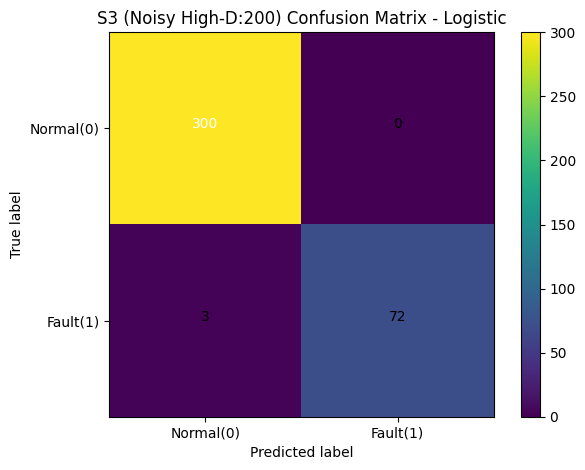

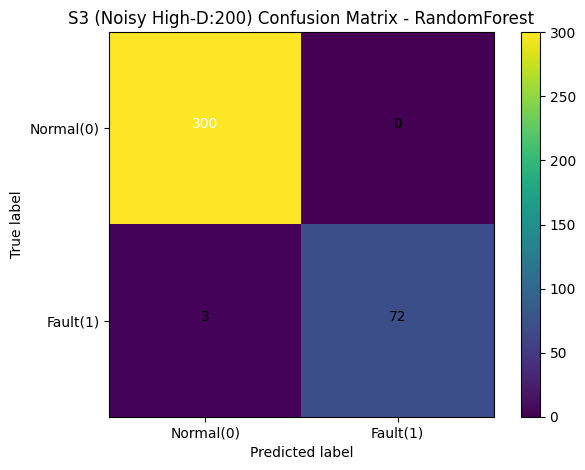

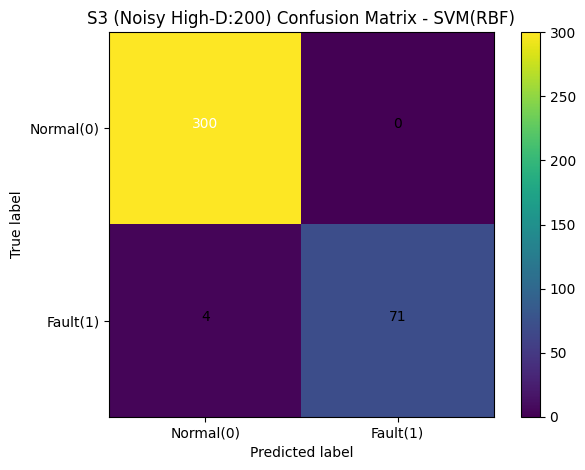

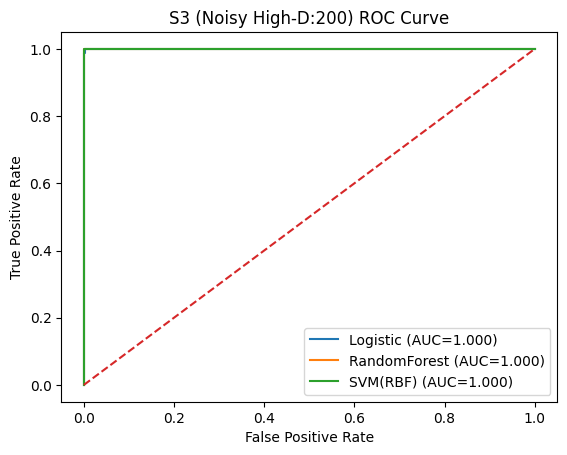

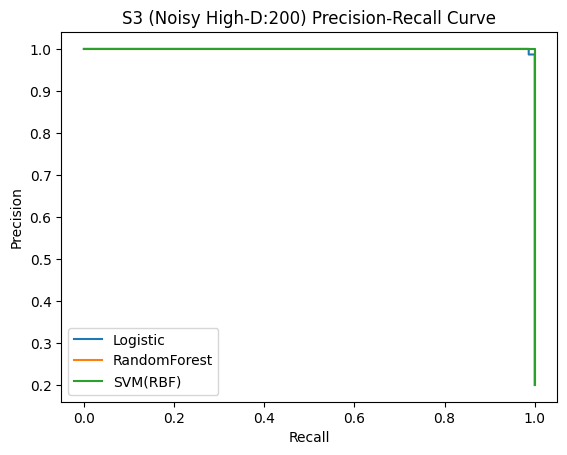

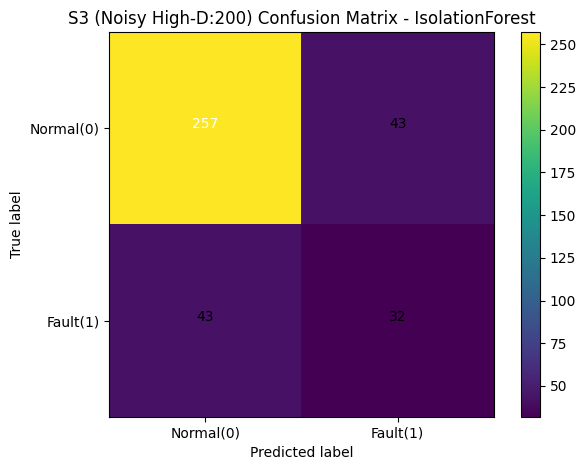

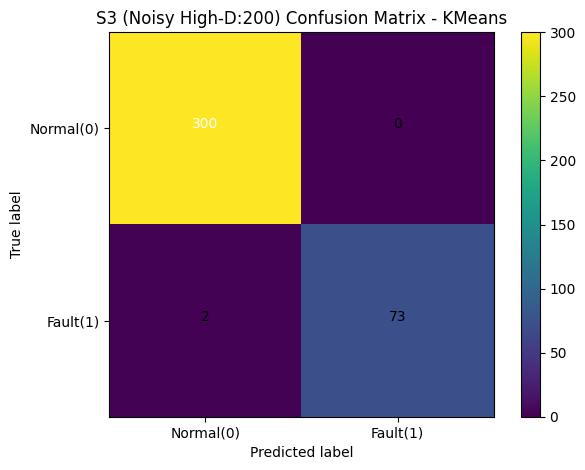


S3 Supervised Metrics:
          Model  Accuracy  Precision    Recall        F1       AUC
1  RandomForest  0.992000        1.0  0.960000  0.979592  1.000000
2      SVM(RBF)  0.989333        1.0  0.946667  0.972603  1.000000
0      Logistic  0.992000        1.0  0.960000  0.979592  0.999956

S3 Unsupervised Metrics:
             Model        F1       AUC
0  IsolationForest  0.426667  0.720133
1           KMeans  0.986486       NaN

【S3 考察】
- AUCトップ: RandomForest, F1トップ: RandomForest
- RFが上位ならノイズ耐性（特徴サブセット＋バギング）の効果。
- Logistic/SVMが劣る場合は、正則化強化（L1/L2）や特徴選択、PCA等の次元削減を検討。


In [ ]:
# ============================================================
# S3：高次元ノイズ（200次元）シナリオ
# 目的：大量の不要特徴（ノイズ）を混ぜ、高次元下でのモデル差を体験する
# 期待：RFが比較的安定しやすい。Logistic/SVMはノイズで汎化が落ちやすい
# ============================================================

# ---- データ生成（ノイズ200次元を追加）----
df_s3 = scenario_dataset(sid=3, noise_dim=200, imbalance=False, label_noise=0.0)

# クラス分布（正常=0 / 異常=1）の確認
print("S3 class balance:", Counter(df_s3['label']))

# ---- 教師ありモデル評価 ----
# Logistic / RandomForest / SVM(RBF) を共通手順で比較
# 可視化：混同行列、ROC曲線、PR曲線を出力
metrics_s3_sup = evaluate_supervised(df_s3, title_prefix="S3 (Noisy High-D:200)")

# ---- 教師なしモデル評価 ----
# IsolationForest / KMeans を比較（教師なしのロバスト性も確認）
metrics_s3_uns = evaluate_unsupervised(df_s3, title_prefix="S3 (Noisy High-D:200)")

# ---- 数値結果の表示 ----
print("\nS3 Supervised Metrics:")
print(metrics_s3_sup)

print("\nS3 Unsupervised Metrics:")
print(metrics_s3_uns)

# ---- AUC・F1のトップモデルを抽出 ----
best_auc_model = metrics_s3_sup.iloc[0]['Model']                      # ROC-AUC最大モデル
best_f1_model = metrics_s3_sup.sort_values('F1', ascending=False).iloc[0]['Model']  # F1最大モデル

# ---- 自動考察の出力 ----
print("\n【S3 考察】")
print(f"- AUCトップ: {best_auc_model}, F1トップ: {best_f1_model}")
print("- RFが上位ならノイズ耐性（特徴サブセット＋バギング）の効果。")
print("- Logistic/SVMが劣る場合は、正則化強化（L1/L2）や特徴選択、PCA等の次元削減を検討。")


# S3：高次元ノイズ（200次元）シナリオ

## 🔍 シナリオ概要
- ベースの5特徴（speed, current, temp, ax, gps_jitter）に **200次元の純ノイズ** を追加。
- 現実の高次元データ（大量のログ特徴、派生特徴、外部特徴を一括投入した状態）を模擬。
- **多くの特徴が学習に無関係**である状況で、各モデルの頑健性を比較する。

---

## 🎯 ねらい
- **RF（ランダムフォレスト）が比較的安定**しやすいことを体験。
- **Logistic / SVM** は高次元ノイズで重み推定やカーネル計算が不利になり、**汎化性能が低下**しやすいことを確認。
- 指標は **ROC-AUC** とともに **F1/PR** にも注目（誤警報・見逃しのバランス）。

---

## 🧠 理論のポイント
- **次元の呪い（Curse of Dimensionality）**：不要次元が多いほど、距離や相似性の概念が崩れ、汎化が難しくなる。
- **RFの頑健性**：各木でランダムな特徴サブセットを使い、**バギング**で平均化→ノイズの影響を相対的に受けにくい。
- **Logistic/SVMの脆弱性**：
  - Logistic：多数の不要重みの推定で分散が増えやすい。  
  - SVM：カーネル距離がノイズで膨らみ識別境界が不安定になりがち（特にRBFのγ・Cに敏感）。

---

## 📊 期待される結果の読み方
- **AUC / F1 のトップがRF**：ノイズ環境での優位性が現れたサイン。  
- Logistic/SVMの **F1低下**（特にRecallやPrecisionの崩れ）があれば、**特徴選択/正則化**の必要性が高い。

---

## 🔧 改善の実務Tips
1. **正則化強化**  
   - Logistic：`penalty='l1'`（L1でスパース化）や `C` の縮小（強い正則化）  
   - SVM：`C` を下げる、`gamma` をチューニング
2. **特徴選択 / 次元削減**  
   - **PCA**（主成分分析）で低次元へ圧縮  
   - **L1（Lasso）**や**RFE**、**SelectKBest** で重要特徴だけを残す
3. **木系の強化学習器**（必要に応じて）  
   - RFの `n_estimators` や `max_features` の調整  
   - 勾配ブースティング系（XGBoost/LightGBM）も候補

---

## 🧪（任意）クイック検証コード例
> 次のセルを追加して、PCA後のLogistic/SVMを試すと効果を確認しやすいです。

```python
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

features = [c for c in df_s3.columns if c != 'label']
X = df_s3[features].values
y = df_s3['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# PCAで50次元に圧縮 → Logistic
pipe_pca_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50, random_state=42)),
    ('clf', LogisticRegression(max_iter=600, C=0.5, penalty='l2'))
])
pipe_pca_lr.fit(X_train, y_train)
y_pred = pipe_pca_lr.predict(X_test)
print("PCA+LR F1:", f1_score(y_test, y_pred))

# PCAで50次元に圧縮 → SVM(RBF)
pipe_pca_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50, random_state=42)),
    ('clf', SVC(kernel='rbf', C=1.0, gamma='scale'))
])
pipe_pca_svm.fit(X_train, y_train)
y_pred = pipe_pca_svm.predict(X_test)
print("PCA+SVM F1:", f1_score(y_test, y_pred))


In [ ]:
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

features = [c for c in df_s3.columns if c != 'label']
X = df_s3[features].values
y = df_s3['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# PCAで50次元に圧縮 → Logistic
pipe_pca_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50, random_state=42)),
    ('clf', LogisticRegression(max_iter=600, C=0.5, penalty='l2'))
])
pipe_pca_lr.fit(X_train, y_train)
y_pred = pipe_pca_lr.predict(X_test)
print("PCA+LR F1:", f1_score(y_test, y_pred))

# PCAで50次元に圧縮 → SVM(RBF)
pipe_pca_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50, random_state=42)),
    ('clf', SVC(kernel='rbf', C=1.0, gamma='scale'))
])
pipe_pca_svm.fit(X_train, y_train)
y_pred = pipe_pca_svm.predict(X_test)
print("PCA+SVM F1:", f1_score(y_test, y_pred))

PCA+LR F1: 0.9726027397260274
PCA+SVM F1: 0.9726027397260274



## 9. S4：不均衡＋ラベルノイズ（class_weight/PR重視）
**理論**：不均衡ではAccuracyが過大評価になりがち。RecallやPRを重視し、class_weightやしきい値を調整する。  
**目的**：重み付けの効果とPR曲線の読み方を体験。


S4 class balance: Counter({0: 1638, 1: 312})


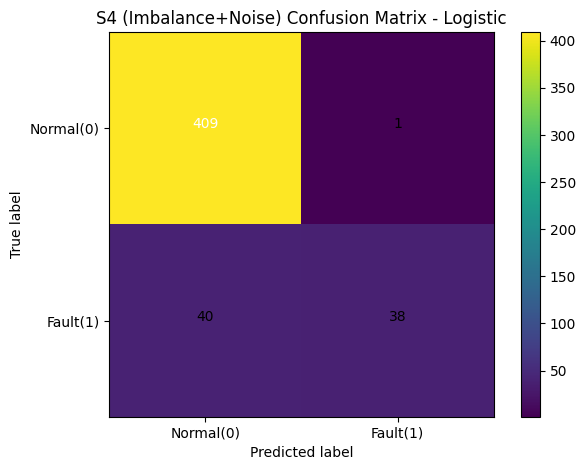

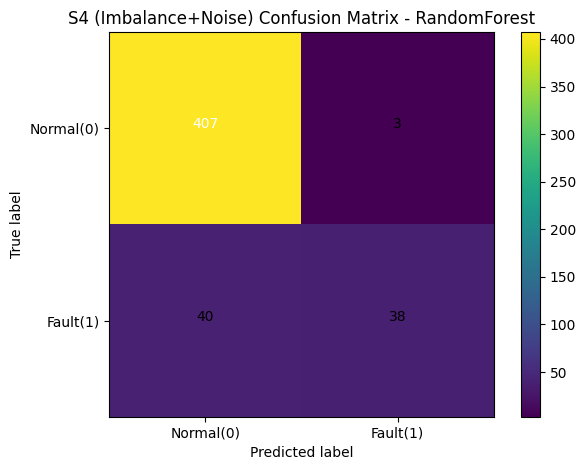

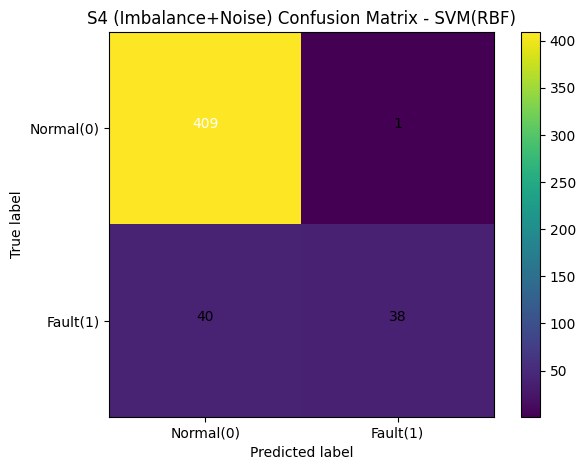

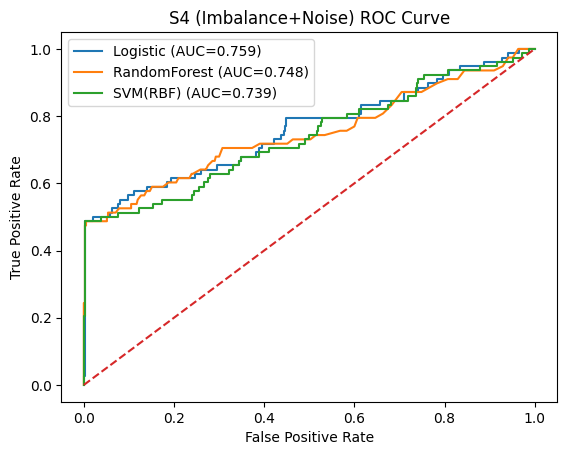

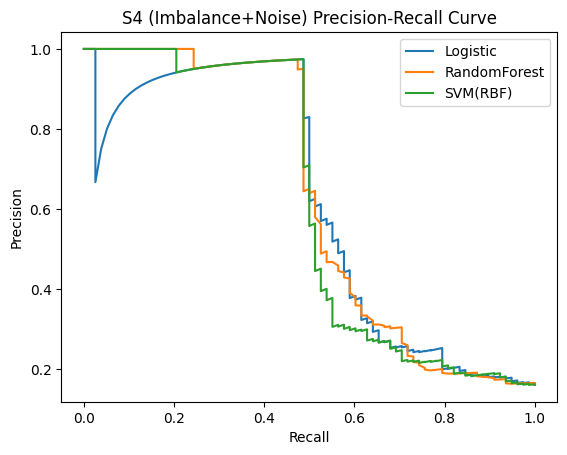

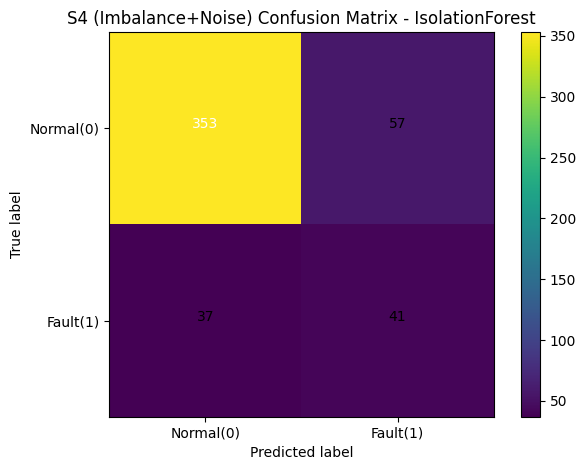

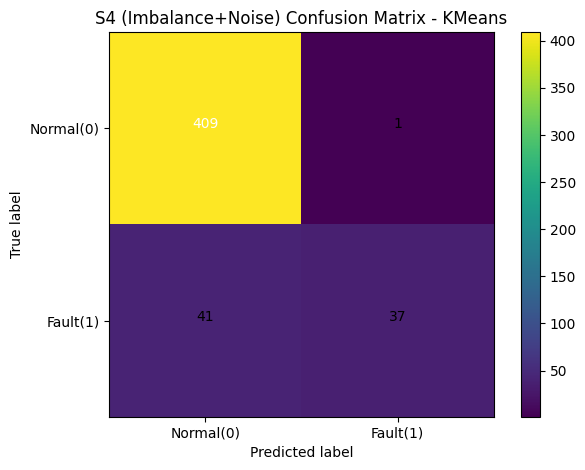


S4 Supervised (no weights):
          Model  Accuracy  Precision    Recall        F1       AUC
0      Logistic  0.915984   0.974359  0.487179  0.649573  0.759162
1  RandomForest  0.911885   0.926829  0.487179  0.638655  0.747780
2      SVM(RBF)  0.915984   0.974359  0.487179  0.649573  0.738837

S4 Supervised (class_weight balanced):
           Model  Accuracy  Precision    Recall        F1       AUC
0  Logistic(bal)  0.854508   0.544304  0.551282  0.547771  0.755159
1        RF(bal)  0.915984   0.974359  0.487179  0.649573  0.749656
2       SVM(bal)  0.911885   0.926829  0.487179  0.638655  0.721857

S4 Unsupervised:
             Model        F1       AUC
0  IsolationForest  0.465909  0.715385
1           KMeans  0.637931       NaN

【S4 考察】
- 重み付け前AUCトップ: Logistic -> 重み付け後AUCトップ: Logistic(bal)
- Recall最大（見逃し最小）: 前=Logistic -> 後=Logistic(bal)
- class_weight によって Recall が改善していれば、不均衡下の見逃し削減に寄与。PR曲線も確認。


In [ ]:
# ============================================================
# S4：不均衡 + ラベルノイズ シナリオ
# 目的：
#  - 陽性(異常=1)が少ない状況で、Accuracyの限界とPR重視の必要性を体験
#  - class_weight='balanced' による効果を比較
#  - 教師なし(ISO/KMeans)との位置付けも確認
# ============================================================

# ---- データ生成：不均衡(正常>>異常) + ラベルノイズ10% ----
df_s4 = scenario_dataset(sid=4, noise_dim=0, imbalance=True, label_noise=0.1)
print("S4 class balance:", Counter(df_s4['label']))  # クラス分布を確認

# ---- 重み付けなし（ベース）の教師あり評価：ROC/PR/混同行列を可視化 ----
metrics_s4_base = evaluate_supervised(df_s4, title_prefix="S4 (Imbalance+Noise)")

# ---- 学習/評価データの準備 ----
features = [c for c in df_s4.columns if c != 'label']
X = df_s4[features].values
y = df_s4['label'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

# ---- 重み付けモデル（不均衡対策）を定義 ----
# Logistic：線形モデルに class_weight='balanced'
pipe_lr_bal = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=600, class_weight='balanced', random_state=RANDOM_STATE))
])

# RandomForest：木系でも class_weight='balanced' を指定（陽性の重みを上げる）
rf_bal = RandomForestClassifier(
    n_estimators=400, class_weight='balanced', random_state=RANDOM_STATE
)

# SVM(RBF)：非線形＋重み付け
pipe_svm_bal = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_STATE))
])

models_bal = {'Logistic(bal)': pipe_lr_bal, 'RF(bal)': rf_bal, 'SVM(bal)': pipe_svm_bal}

# ---- 重み付けモデルの評価（数値比較表を自作）----
rows_bal = []
for name, mdl in models_bal.items():
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)  # 0/1 予測（デフォルトしきい値=0.5相当）

    # 基本指標
    acc = (y_pred == y_test).mean()
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)

    # ROC-AUC算出のための連続スコア（確率または決定関数）
    if hasattr(mdl, "predict_proba"):
        y_score = mdl.predict_proba(X_test)[:, 1]
    else:
        y_score = mdl.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_val = auc(fpr, tpr)

    rows_bal.append([name, acc, prec, rec, f1, auc_val])

# AUC降順で見やすく
metrics_s4_bal = pd.DataFrame(
    rows_bal, columns=['Model','Accuracy','Precision','Recall','F1','AUC']
).sort_values('AUC', ascending=False)

# ---- 教師なし（参考）：ISO/KMeans ----
metrics_s4_uns = evaluate_unsupervised(df_s4, title_prefix="S4 (Imbalance+Noise)")

# ---- 出力 ----
print("\nS4 Supervised (no weights):")
print(metrics_s4_base)

print("\nS4 Supervised (class_weight balanced):")
print(metrics_s4_bal)

print("\nS4 Unsupervised:")
print(metrics_s4_uns)

# ---- どのモデルが良かったかの要約（自動考察の種）----
best_auc_base = metrics_s4_base.iloc[0]['Model']                 # 重み付け前のAUCトップ
best_auc_bal  = metrics_s4_bal.iloc[0]['Model']                  # 重み付け後のAUCトップ
rec_base_max  = metrics_s4_base.sort_values('Recall', ascending=False).iloc[0]['Model']
rec_bal_max   = metrics_s4_bal.sort_values('Recall', ascending=False).iloc[0]['Model']

print("\n【S4 考察】")
print(f"- 重み付け前AUCトップ: {best_auc_base} -> 重み付け後AUCトップ: {best_auc_bal}")
print(f"- Recall最大（見逃し最小）: 前={rec_base_max} -> 後={rec_bal_max}")
print("- class_weight によって Recall が改善していれば、不均衡下の見逃し削減に寄与。PR曲線も確認。")

# ---（任意実験のヒント）---
# さらにRecallを上げたい場合は、確率しきい値(0.5)を下げることで見逃しを減らせる。
# y_score >= 0.3 のように閾値を操作し、PR曲線で運用点を選ぶのが実務的。


# S4：不均衡 + ラベルノイズ（Imbalance + Label Noise）

## 🔍 シナリオ概要
- **不均衡**：正常(0)が大多数、異常(1)が少数（例：12:1 程度）
- **ラベルノイズ**：正解ラベルの一部（例：10%）が誤っている状況
- 実務でもよく起こる厳しい条件（人手ラベルのミス、希少イベント、記録抜けなど）

---

## 🎯 ねらい
1. **Accuracy の限界**を体感（不均衡では高く見えても意味が薄い）
2. **Recall / Precision / F1 / PR曲線** の重要性を理解
3. **class_weight='balanced'** が **Recall 改善** や **AUC 変化**にどう効くか比較

---

## 🧠 理論のポイント
- **Accuracy の罠**：99%が正常なら、全部0と予測してもAccuracy=99%になりうる。  
  → 不均衡では **Recall（見逃し率）** と **PR曲線** を重視。
- **class_weight='balanced'**：  
  学習時に **少数クラス（異常）を重く**扱い、**見逃しを減らす**方向に寄与。
- **ラベルノイズ**：  
  誤ラベルがあると、どのモデルでも上限性能が下がる。  
  → 過度なフィットを避け、**正則化/木の浅さ**/しきい値調整で安定性を確保。

---

## 📊 結果の見方
- **Recall が上がっているか？**（見逃し防止が目的なら最重要）  
- **PR曲線（Precision–Recall）**で運用点を選択：  
  - 警報を増やしても見逃しを防ぎたい→**Recall重視**  
  - 誤警報を抑えたい→**Precision重視**
- **AUC（ROC）**は全体傾向を見るのに有効だが、**不均衡ではPRの方が実務適合**。

---

## 🔧 実務Tips（さらに性能を攻める）
1. **しきい値調整（重要）**  
   - 0/1 予測のデフォルトは 0.5。  
   - `y_score >= τ` の **τ を下げる**と **Recall↑ / Precision↓**（見逃し減るが誤報増）。  
   - PR曲線上で**ビジネス・運用コスト**に合う点を選ぶ。
2. **コスト敏感学習**  
   - 誤検知コスト＜見逃しコスト なら、**Recall優先**の閾値設定や重み付け強化。
3. **データ側の工夫**  
   - **再ラベリング/監査**でノイズ低減。  
   - **サンプリング法**（少数クラスのオーバーサンプリングやSMOTE）の検討。  
   - **特徴拡張**：異常時にのみ増える派生指標（移動分散、ピーク率、変化率など）

---

## 🧪（任意）しきい値スイープのミニコード
```python
# 例：Logistic(bal) のスコアでしきい値を変えたときのF1/Precision/Recallを確認
mdl = pipe_lr_bal.fit(X_train, y_train)
y_score = mdl.predict_proba(X_test)[:,1]

def metrics_at(th):
    y_hat = (y_score >= th).astype(int)
    return (precision_score(y_test, y_hat, zero_division=0),
            recall_score(y_test, y_hat, zero_division=0),
            f1_score(y_test, y_hat, zero_division=0))

for th in [0.5, 0.4, 0.3, 0.2]:
    p, r, f = metrics_at(th)
    print(f"th={th:.1f} -> Precision={p:.3f}, Recall={r:.3f}, F1={f:.3f}")



